In [2]:
import config
import spotipy
import json
from spotipy.oauth2 import SpotifyClientCredentials
import numpy as np
import pandas as pd
import pickle
from sklearn import datasets # sklearn comes with some toy datasets to practise
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from matplotlib import pyplot
from sklearn.metrics import silhouette_score
import random
import seaborn as sns

#Initialize SpotiPy with user credentias
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id= config.client_id,
                                                           client_secret= config.client_secret))

In [19]:
df = pd.read_csv("songs_byplaylist_bygenres.csv")
df.describe()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
count,73363.000000,73363.000000,73363.000000,73363.000000,73363.000000,73363.000000,73363.000000,73363.000000,73363.000000,7.336300e+04
mean,0.571666,0.585020,-9.606646,0.084714,0.337416,0.181970,0.184051,0.474739,119.519258,2.299611e+05
std,0.185722,0.268684,6.761314,0.091120,0.344895,0.336221,0.155988,0.259037,30.233595,1.622000e+05
min,0.000000,0.000000,-53.436000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.229000e+03
25%,0.459000,0.408000,-11.225000,0.036100,0.028100,0.000000,0.095800,0.265000,95.990000,1.773700e+05
50%,0.590000,0.629000,-7.521000,0.048700,0.194000,0.000090,0.119000,0.472000,119.924000,2.121220e+05
75%,0.708000,0.803000,-5.353500,0.087900,0.632000,0.102000,0.220000,0.681000,139.284500,2.524130e+05
max,0.987000,1.000000,1.358000,0.961000,0.996000,1.000000,0.995000,0.999000,240.107000,6.000661e+06


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73365 entries, 0 to 73364
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      73363 non-null  float64
 1   energy            73363 non-null  float64
 2   loudness          73363 non-null  float64
 3   speechiness       73363 non-null  float64
 4   acousticness      73363 non-null  float64
 5   instrumentalness  73363 non-null  float64
 6   liveness          73363 non-null  float64
 7   valence           73363 non-null  float64
 8   tempo             73363 non-null  float64
 9   id                73363 non-null  object 
 10  duration_ms       73363 non-null  float64
dtypes: float64(10), object(1)
memory usage: 6.2+ MB


##### decision we made regarding the columns to keep or not in the dataset

- In previous analysis we noticed that the duration_ms seem to be defining an entire cluster by itself. The previous models were'nt working well so we decided to get rid of this column


In [20]:
df = df.drop('duration_ms', axis=1)
df.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id
0,0.585,0.239,-15.167,0.0309,0.697,0.001330,0.159,0.0933,101.182,5CQHTuNbYlEA4fZdxQ4PMi
1,0.463,0.368,-11.546,0.0480,0.376,0.000000,0.149,0.7500,141.974,3LHg768dEKqJKht2uPTlVR
2,0.561,0.327,-10.835,0.0327,0.902,0.000469,0.111,0.2980,161.858,3bHhUEOTIbezeZ856R0BX5
3,0.481,0.638,-5.862,0.0276,0.153,0.000000,0.154,0.4970,79.064,2hKdd3qO7cWr2Jo0Bcs0MA
4,0.643,0.495,-10.176,0.0292,0.421,0.001230,0.082,0.3190,127.219,615auKcis6sGDrHk6UTeog


##### None values are not allowed in the dataset for the elbow analysis so we need to drop them

In [21]:
# drop null values rows
df.dropna(axis = 0, inplace = True)

##### Duplicates of same songs could affect the mean calculated to establish the clusters

In [22]:
#check for duplicates
before = len(df)
data = df.drop_duplicates()
after = len(df)
print('Number of duplicate records dropped: ', str(before - after))

Number of duplicate records dropped:  0


In [10]:
#we just realised that we can't filter out the duplicates because songs with same artist and title could have different ids if they are in different playlists! 
# we sould have used this to select the real duplicates before extracting the data
# duplicates_names_artist = df[df.duplicated(['name', 'artists'])]

In [23]:
df.set_index('id', inplace=True)
df.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
id,,,,,,,,,
5CQHTuNbYlEA4fZdxQ4PMi,0.585,0.239,-15.167,0.0309,0.697,0.001330,0.159,0.0933,101.182
3LHg768dEKqJKht2uPTlVR,0.463,0.368,-11.546,0.0480,0.376,0.000000,0.149,0.7500,141.974
3bHhUEOTIbezeZ856R0BX5,0.561,0.327,-10.835,0.0327,0.902,0.000469,0.111,0.2980,161.858
2hKdd3qO7cWr2Jo0Bcs0MA,0.481,0.638,-5.862,0.0276,0.153,0.000000,0.154,0.4970,79.064
615auKcis6sGDrHk6UTeog,0.643,0.495,-10.176,0.0292,0.421,0.001230,0.082,0.3190,127.219


In [24]:
scaler = StandardScaler()
scaler.fit(df)
df_scaled = scaler.transform(df)
df_scaled_df = pd.DataFrame(df_scaled, columns = df.columns)
display(df.head())
print()
display(df_scaled_df.head())

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
id,,,,,,,,,
5CQHTuNbYlEA4fZdxQ4PMi,0.585,0.239,-15.167,0.0309,0.697,0.001330,0.159,0.0933,101.182
3LHg768dEKqJKht2uPTlVR,0.463,0.368,-11.546,0.0480,0.376,0.000000,0.149,0.7500,141.974
3bHhUEOTIbezeZ856R0BX5,0.561,0.327,-10.835,0.0327,0.902,0.000469,0.111,0.2980,161.858
2hKdd3qO7cWr2Jo0Bcs0MA,0.481,0.638,-5.862,0.0276,0.153,0.000000,0.154,0.4970,79.064
615auKcis6sGDrHk6UTeog,0.643,0.495,-10.176,0.0292,0.421,0.001230,0.082,0.3190,127.219


,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.071794,-1.287845,-0.822383,-0.590588,1.042597,-0.537269,-0.160595,-1.472534,-0.606523
1,-0.585107,-0.807723,-0.286833,-0.402922,0.111873,-0.541225,-0.224703,1.062640,0.742713
2,-0.057432,-0.960320,-0.181675,-0.570834,1.636984,-0.539830,-0.468314,-0.682295,1.400397
3,-0.488187,0.197183,0.553838,-0.626805,-0.534704,-0.541225,-0.192649,0.085940,-1.338099
4,0.384091,-0.335045,-0.084208,-0.609245,0.242349,-0.537566,-0.654227,-0.601225,0.254677


## Chosing K

### elbow method

Training a K-Means model with 2 clusters! 

Training a K-Means model with 3 clusters! 

Training a K-Means model with 4 clusters! 

Training a K-Means model with 5 clusters! 

Training a K-Means model with 6 clusters! 

Training a K-Means model with 7 clusters! 

Training a K-Means model with 8 clusters! 

Training a K-Means model with 9 clusters! 

Training a K-Means model with 10 clusters! 

Training a K-Means model with 11 clusters! 

Training a K-Means model with 12 clusters! 

Training a K-Means model with 13 clusters! 

Training a K-Means model with 14 clusters! 

Training a K-Means model with 15 clusters! 

Training a K-Means model with 16 clusters! 

Training a K-Means model with 17 clusters! 

Training a K-Means model with 18 clusters! 

Training a K-Means model with 19 clusters! 

Training a K-Means model with 20 clusters! 



Text(0.5, 1.0, 'Elbow Method showing the optimal k')

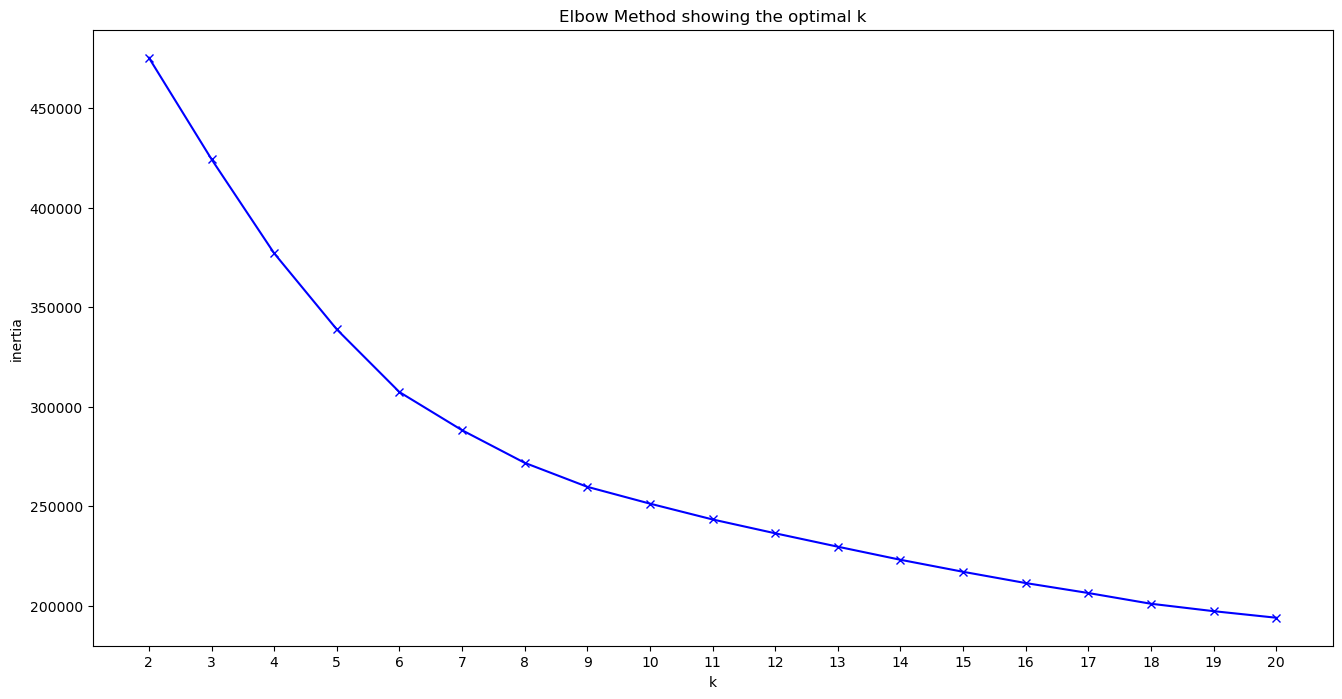

In [25]:
K = range(2, 21)
inertia = []

for k in K:
    print("Training a K-Means model with {} clusters! ".format(k))
    print()
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(df_scaled_df)
    inertia.append(kmeans.inertia_)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

## Silouhette

In [10]:
K = range(2, 20)
silhouette = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(df_scaled_df)
    
    filename = "kmeans_" + str(k) + ".pickle"
    with open(filename, "wb") as f:
        pickle.dump(kmeans,f)
    
    silhouette.append(silhouette_score(df_scaled_df, kmeans.predict(df_scaled_df)))


plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Silhouette Method showing the optimal k')

MemoryError: Unable to allocate 1.00 GiB for an array with shape (1829, 73363) and data type float64

In [26]:
#another representaitron of silhouhette plot: 
from yellowbrick.cluster import SilhouetteVisualizer
model = KMeans(k, random_state=42)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(df_scaled_df)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

MemoryError: Unable to allocate 1.00 GiB for an array with shape (1829, 73363) and data type float64

## Clustering the songs with K-Means

In [66]:
kmeans = KMeans(n_clusters=16, random_state=1234)
kmeans.fit(df_scaled_df)

KMeans(n_clusters=16, random_state=1234)

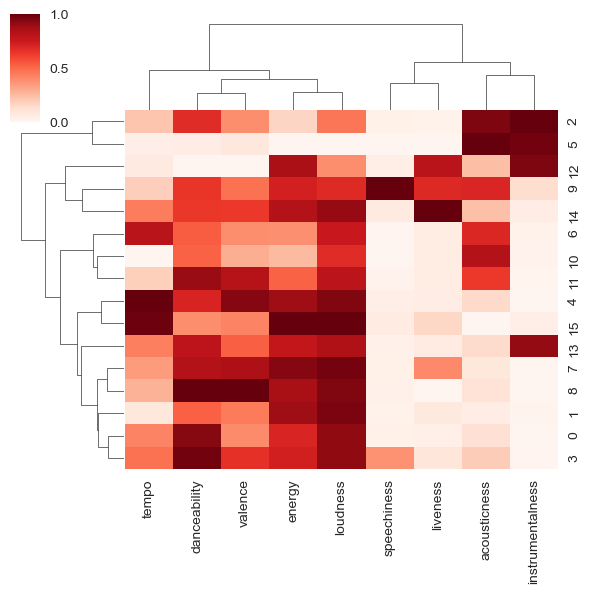

In [83]:
import seaborn as sns
columns_no_id = ["danceability","energy","loudness","speechiness","acousticness",
    "instrumentalness","liveness","valence","tempo"]
#sns.heatmap(pd.DataFrame(kmeans.cluster_centers_,columns = columns_no_id),cmap="Reds")
sns.clustermap(pd.DataFrame(kmeans.cluster_centers_,columns = columns_no_id), cmap='Reds', standard_scale=1, method='ward', figsize=(6, 6))

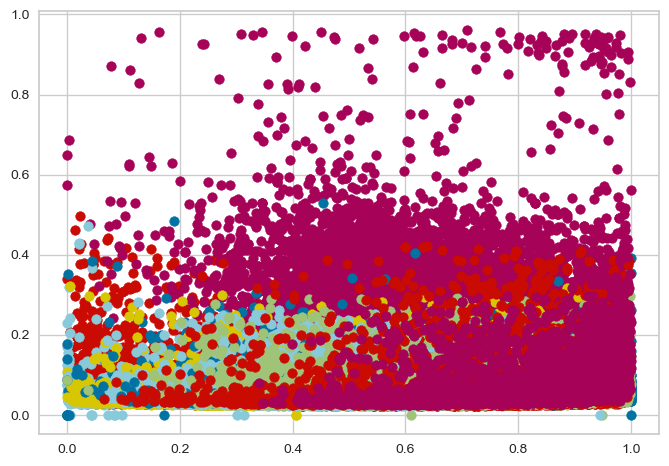

In [84]:
# assign a cluster to each example
labels = kmeans.predict(df_scaled_df) #same as kmeans.labels_
# retrieve unique clusters
clusters = np.unique(labels)
# create scatter plot for samples from each cluster
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = np.where(labels == cluster)
    # create scatter of these samples
    pyplot.scatter(df.to_numpy()[row_ix, 1], df.to_numpy()[row_ix, 3]) #1 and 3 define the index of colums axes to be used for the visualization. But know that all the columns are ploted
    # show the plot
pyplot.show()

Now we have our "model", let's get the clusters and how many observations has each cluster.

In [85]:
clusters = kmeans.predict(df_scaled_df)
pd.Series(clusters).value_counts().sort_index()

0     6706
1     6036
2     4490
3     5454
4     5022
5     4318
6     4192
7     5099
8     9464
9      196
10    4488
11    5509
12     738
13    3986
14    2597
15    5068
dtype: int64

Now let's see to which group was assigned every song

In [86]:
df["cluster"] = clusters
df

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,cluster
id,,,,,,,,,,
5CQHTuNbYlEA4fZdxQ4PMi,0.585,0.239,-15.167,0.0309,0.697000,0.001330,0.159,0.0933,101.182,10
3LHg768dEKqJKht2uPTlVR,0.463,0.368,-11.546,0.0480,0.376000,0.000000,0.149,0.7500,141.974,6
3bHhUEOTIbezeZ856R0BX5,0.561,0.327,-10.835,0.0327,0.902000,0.000469,0.111,0.2980,161.858,6
2hKdd3qO7cWr2Jo0Bcs0MA,0.481,0.638,-5.862,0.0276,0.153000,0.000000,0.154,0.4970,79.064,1
615auKcis6sGDrHk6UTeog,0.643,0.495,-10.176,0.0292,0.421000,0.001230,0.082,0.3190,127.219,0
...,...,...,...,...,...,...,...,...,...,...
0uctKVLlfFjhYRnJaDaYXM,0.436,0.915,-3.929,0.0562,0.000086,0.000005,0.348,0.4210,162.049,15
4O7PMEWkbHDS1TJhH0ZBqi,0.490,0.905,-3.829,0.0598,0.000016,0.000757,0.341,0.5590,90.974,7
6JKwPN8ThWw1ofH8BFMzXV,0.579,0.949,-1.971,0.0611,0.000037,0.000053,0.101,0.6390,125.126,8


# Saving with pickle

In [87]:
import pickle

#scaler = StandardScaler()
#model = KMeans()

with open("song_recom_scaler.pickle", "wb") as f: 
    pickle.dump(scaler,f) 

with open("song_recom_kmeans.pickle", "wb") as f:
    pickle.dump(kmeans,f)

In [88]:
def load(filename = "filename.pickle"): 
    try: 
        with open(filename, "rb") as f: #rb in this cas is reading permission
            return pickle.load(f) 
        
    except FileNotFoundError: # if we don't add this error it will give an error and the running will stop
        print("File not found!") 


...

...

# Recommend a song based on customer favorite song

## Input the song and get credendials from spotify

In [189]:
song = input('what is your favorite song:')

what is your favorite song:oops i did it again


In [190]:
results = sp.search(q=song,limit=1,market="US") #top 3 limits and market great britan
results
track_id = results["tracks"]["items"][0]["id"]

## Scaling and applying the model on new song

In [191]:
columns = ["danceability","energy","loudness","speechiness","acousticness",
    "instrumentalness","liveness","valence","tempo","id"]

In [192]:
#getting the audio features of the song
track_features = sp.audio_features(track_id)
df_track_features = pd.DataFrame(track_features)
df_track_features=df_track_features[columns]

df_track_features.set_index('id', inplace=True)
input_id = df_track_features.index[0]

In [193]:
from IPython.display import IFrame
def play_input_song(input_id):
    return IFrame(src="https://open.spotify.com/embed/track/"+input_id,
       width="320",
       height="80",
       frameborder="0",
       allowtransparency="true",
       allow="encrypted-media",
      )
play_song(input_id)

In [194]:
input_id

'6naxalmIoLFWR0siv8dnQQ'

In [195]:
audio_features_selected = ["danceability","energy","loudness","speechiness","acousticness",
    "instrumentalness","liveness","valence","tempo"]

In [196]:
saved_scaler = load("song_recom_scaler.pickle")
scaled_user_input_song = saved_scaler.transform(df_track_features)
df_scaled_user_input_song = pd.DataFrame(scaled_user_input_song, columns=audio_features_selected)
display(df_scaled_user_input_song.head())

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.965611,0.92667,0.615661,-0.450113,-0.108485,-0.541172,1.095924,1.618548,-0.809246


In [197]:
saved_mode = load("song_recom_kmeans.pickle")
closest_cluster_label = saved_mode.predict(df_scaled_user_input_song)
closest_cluster_label

array([7])

In [198]:
cluster_indices = np.where(labels == closest_cluster_label)[0]

In [199]:
cluster_df = df[df["cluster"] == int(closest_cluster_label)]

# Select a random song from the cluster
random_song = cluster_df.sample(n=1)
random_song.reset_index(inplace = True)
output_id = random_song.id[0]

In [200]:
output_id

'1hkm127hnTSa2xjGNw8IAE'

def recommend_song(track_id,saved_scaler,saved_mode,audio_features_selected,df):
    ## get the audio features of the userSong
    track_features=sp.audio_features(track_id)[0]
    ## only filter the features that has been used for clustering
    userInputSong=np.array(list(dict((k, userInputSong[k]) for k in audio_features_selected).values())).reshape(1,-1)

    ##scaling the new song
    scaled_user_input_song =saved_scaler.transform(userInputSong)
    
    ## find the closest cluster to the userSong
    closest_cluster_label=saved_mode.predict(scaled_user_input_song)[0]
    
    ## return the track id from a random song within the closest cluster
    cluster_indices = np.where(labels == closest_cluster_label)[0]
    cluster_df = df[df["cluster"] == int(closest_cluster_label)]
    random_song = cluster_df.sample(n=1)
    random_song.reset_index(inplace = True)
    random_song.id[0]

In [201]:
from IPython.display import IFrame
def play_output_song(output_id):
    return IFrame(src="https://open.spotify.com/embed/track/"+output_id,
       width="320",
       height="80",
       frameborder="0",
       allowtransparency="true",
       allow="encrypted-media",
      )
play_output_song(output_id)

## Output the name of the song the artist and the album

In [ ]:
#results["tracks"]["items"][0]["artists"] # Track artists
#results["tracks"]["items"][0]["id"] # Track ID
#results["tracks"]["items"][0]["name"] # Track name
#results["tracks"]["items"][0]["popularity"] # Popularity index